<a href="https://colab.research.google.com/github/Glifoyle/test-repo/blob/master/CVBDLU3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--------------------------------------------------
INTRODUCTION TO COMPUTER VISION AND DEEP LEARNING
----------------------------------


**NOTE:** The following cell will donwload files to the drive of the remote computer that google is using. Be sure to run this cell every time as the files will be deleted at the end of each session.

In [ ]:
import os
if not os.path.exists('Zao_site5'):
    !wget https://www.dropbox.com/s/isghadlhjln1qy7/Zao_site5.zip?dl=0
    !mv Zao_site5.zip?dl=0 Zao_site5.zip
    !unzip Zao_site5.zip
    !rm Zao_site5.zip

--2023-07-12 05:57:43--  https://www.dropbox.com/s/isghadlhjln1qy7/Zao_site5.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/isghadlhjln1qy7/Zao_site5.zip [following]
--2023-07-12 05:57:44--  https://www.dropbox.com/s/raw/isghadlhjln1qy7/Zao_site5.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaf884e137511047ec45be40ec8.dl.dropboxusercontent.com/cd/0/inline/B_siLWgpYmOockN-ICgonUPvODi1zi-D8Cv3IiWqYjsAe7ZJ_g9E5i36eT2ai9tFIV25nMY4nLDOfr5Y8ZuBizEUAXLMqL4r9X6M8yPKi7JJBJ25HZojMMCC1e8jkc4zIuqb2iusRrEaO6XjlWkfwWpvhpKAUDJDGIRzELXYVWf2Cw/file# [following]
--2023-07-12 05:57:44--  https://ucaf884e137511047ec45be40ec8.dl.dropboxusercontent.com/cd/0/inline/B_siLWgpYmOockN-ICgonUPvODi1zi-D8Cv3IiWqYjsAe7ZJ_g9E5i36eT2ai9tFIV25n

# UNIT 3, CONNECTED COMPONENTS FOR PATCH EXTRACTION

There are many different algorithms in Computer Vision, some of them are very simple and some of them are quite complex. There are many courses available online that will introduce you to some of these algorithms. Most frequently, the data used in these courses to illustrate the results of the algorithms are pictures of famous peoples or paintings or even the face of the person teaching the course.

In this course we take a different approach. All the data that we use comes from one part or another of our research, so you can see how the algorithms work with real research data. This will invariably results in some ugliness in some of our results, because real data always has unexpected characteristics or presents problems, but it will also give you a much better view of what to expect when you try to adapt this to your own work. Also, if you are interested in drone-acquired image processing you are in luck as this will be our main source of examples.

In this notebook we will use real data acquired [around here](https://goo.gl/maps/rFeSqGA1BdNb9tTM7) using a [Mavic 2 pro UAV](https://www.dji.com/jp/mavic-2) depicting Dead Fir trees due to an insect infestation as well as some types of subalpine vegetation that we will be having a bit of a look at:

1) We will load an orthomosaic constructed from the drone images  
2) We will also load several ground truth annotations made by the forest scientists in the group led by [this guy](https://www.tr.yamagata-u.ac.jp/~larry/profile.html).  
3) We will use the annotations that mark where each bush is to cut small parts of the orthomosaic, each corresponding to one particular bush.  
4) Then, we will assign the correct category to each bush using the expert annotations that show the distribution of species.
5) Finally, we will store our categorised patches in a folder so we can, in another lesson, feed them to a deep learning classifier.


<span style='color:Blue'> If you want, you can download the data used in this notebook (free, without need to install anything) [HERE!(DOWNLOAD LINK!!!)](https://www.dropbox.com/sh/y2c8orandevc5kr/AAD0id7E_e65wWW-5EyDhDIza?dl=0) </span>


## Loading and Visualizing the Data


Let's get to it!, first let's get some imports that we are going to need:

In [ ]:
# important imports
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os

# This will allow the images that we create to be displayed nicely within the notebook
%matplotlib inline

I hope there were no big surprises there:
- cv2 stands for opencv, which we will use for image manipulation and also for our computer vision algorithms.  
- matplotlib is not strictly necessary for the code but we will use it to make some pretty pictures that hopefully will help ilustrate what we are doing (that is also why we are using it "online").
- numpy is a very fast library to manipulate lists of numbers. As we saw in the introduction lesson of this course, images are nothing but matrices of pixels, so numpy will come in handy.  
- Finally, as we will also be creating folders to store files into and work with paths in a way that will hopefully work regardless of what operating system you are using while running this notebook, we will also need the "os" library.

Now let's get on with the coding. First we are going to define a couple of functions to load our images. We will be working with two main types of images:

1) and RGB image containing an [orthomosaic](https://www.dronegenuity.com/orthomosaic-maps-explained/) of a forest area.  
2) Several binary images that contain the annotations that the expert made to show us what can be seen in the orthomosaic. These annotations are crucial because through them we can incorporate the expert knowledge of the forest science specialist in our Data Science team to the image automatic processing pipeline.  

We will basically use opencv to read and handle there images, but we are going to add a little bit more work to the action of reading images so we are going to build two "wrapper functions" that essentially call the imread method of opencv with just a tiny bit more.

Let's see them:

In [ ]:
# Let's define a couple of Functions to read images

#Read color image
def read_Color_Image(path):
    retVal = cv2.imread(path,cv2.IMREAD_COLOR)
    if retVal is None: raise Exception("Reading Color image, something went wrong with the file name "+str(path))
    return retVal

#Read binary image
def read_Binary_Mask(path):
    retVal = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    if retVal is None: raise Exception("Reading GRAYSCALE image, something went wrong with the file name "+str(path))
    retVal[retVal<=50] = 0
    retVal[retVal>50] = 255
    return retVal

In both functions we just read the image passed to us with the path and check that the file was read correctly. If it was not, we throw an [exception](https://realpython.com/python-exceptions/). In the case of binary masks, we binnarize the images by using operations that look at images as if they were numpy arrays, we turn any value smaller or equal to 50 into 0 and all other values into 255 to have pure binary images.

Now we are ready to use these functions to load our data.

<span style='color:Red'> Please make sure to run this cell without problems so you know that you can access the data properly!!!! </span>

In [ ]:
# Read Mosaic and Tops image. The "Zao_site5" folder should be in the same folder as this notebook.
pathMosaic = os.path.join("Zao_site5","site5_mosaic.jpg")
mosaic = read_Color_Image(pathMosaic)
pathTops = os.path.join("Zao_site5","site5_mosaic.jpg")
tops = read_Binary_Mask("Zao_site5/biggerTops.jpg")

# Translate from BGR to RGB (this is only to show the images in real color)
mosaic = mosaic[:,:,::-1]

The paths above should work regardless of your operating system, but you should have your data folder in the same folder as this jupyter notebook.

Now we have our RGB data in the "mosaic" variable and a binary mask that shows where the bushes are as black dots. Let's visualize them using matplotlib:

In [ ]:
plt.rcParams['figure.figsize'] = [100, 100]
f, axarr = plt.subplots(2,1,squeeze=False)
axarr[0][0].imshow(mosaic)
axarr[1][0].imshow(tops,cmap=plt.cm.gray)
plt.show()

We can even show them overlapped to make sure that the black dots are really marking where the bushes are:

In [ ]:
plt.rcParams['figure.figsize'] = [100, 100]
plt.imshow(mosaic)
plt.imshow(tops,cmap=plt.cm.gray,alpha=0.5)
plt.show()

## Extracting Patches from a Binary mask of dots

So far we have ony loaded a couple of images and shown them. Let us put the magic of computer vision algorithms to good use:

First, we are going to use the information stored in the "tops" binary mask to build one image that pictures each of the bushes in our mosaic.

Specifically, the "tops" image is a binary image where the black regions (small circles or dots) mark each of the bushes in our mosaic.

We want to extract the location (the x and y pixel coordinates) of each bush from this binary mask. In order to do this, we will use an opencv algorithm that takes a binary image and computes its [connected component](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga5ed7784614678adccb699c70fb841075).

In [ ]:
def list_from_mask(mask):
    # Compute connected components
    _, _, _, centroids = cv2.connectedComponentsWithStats(255-mask)

    return centroids[1:]

Specifically, what we are doing here is receiving a binary image and getting back a list of the centroids of each black region in the image (the points marking our bushes). To do so we use the _connectedComponentsWithStats()_ opencv method that returns the connected components of a white image of over black background. Because of this discrepancy (in our image the information is black and the background is white but the method expects this in reverse) we call the method with 255-mask as an argument. The method return lots of other information but we are only interested in the last return value, the list of centroids of all the connected components. As the first element of that list is always the background centroid, we ignore it and return the list starting at its second value.

Let's just call this function and have a look at what we get:

In [ ]:
# Let us find the list of centroids in our binary image
cs = list_from_mask(tops)

print(cs)

[[14362.  1721.]
 [13592.  1780.]
 [10407.  1808.]
 ...
 [ 2355. 12067.]
 [ 2291. 12080.]
 [ 2331. 12144.]]


We have obtained a list of the coordinates of the points that indicate where each bush is. Now, we will use the fact that images are just matrices of pixels to cut patches of a given size around each of these points

In [ ]:
def get_Square(w_size, p, img):
    return img[int(p[0])-w_size//2:int(p[0])+w_size//2, int(p[1])-w_size//2:int(p[1])+w_size//2]

def create_Patch(mosaic, center ,patchSize,convert = False):
    patchimage = get_Square(patchSize, (center[1],center[0]), mosaic)
    return cv2.cvtColor(patchimage, cv2.COLOR_BGR2RGB) if convert else patchimage

# Cut a patch around each top
def patches_from_tops(mosaic,tops,size, convert = False):
    return [create_Patch(mosaic, c ,size,convert) for c in tops]

Specifically:

1) The patches_from_tops function iterates over all tops and calls the function to create the patches.  
2) This function, called create_Patch, calls a another function called get square to actually cut the part of the image that we want and, if necessary, transforms from RGB to BGR or vice-versa.  
3) The get_Square function simply cuts a square patch of the correct size around a given point.

Notice some python programming going on up here (lots of not absoultely crucial techical details follow):

- We have used a list comprehension in function patches_from_tops to make the code more compact.  
- We have used a ternary conditional operator in the create_Patch function as well as a boolean flag that will change from BGR to RGB and vice-versa.
- In what I can only describe as "not a totally helpful decision" opencv choose to refer to the coordinates of the points that are returned by its algorithms in (y,x) order where y would be the column and x would be the row as they appear in the image. I believe this may be called "column major order" and I am positive that it is an absolute annoyance, but if you were wondering why the "get_Square" function receives the point as (center[1],center[0]), that is the reason. The connected components function also returns the coordinates of the centroids as "float" values but we need "int" to index pixels, so a casting to int happens inside of the get_Square function.

Now we are ready to make those patches. We will make two versions, ones that we will store in files later and other ins RGB format that we can now visualize.

In [ ]:
patches = patches_from_tops(mosaic,cs,100,True)

# select and show a few random patches
toShow = 30

patches_to_show = patches_from_tops(mosaic,cs,100)
np.random.shuffle(patches_to_show)

f, axarr = plt.subplots(toShow//5,5)
plt.rcParams['figure.figsize'] = [100, 100]
for i in range(toShow//5):
    for j in range(5):
        axarr[i][j].imshow(patches_to_show[i*5+j])

plt.show()

So far we have built a patch around each of the points that the forestry experts in our team marked to show where the bushes are. Our final goal will be to automatically classify these patches with a deep learning network (in a future unit). To be able to do this we need to know what species each patch belongs to.

We already have this information, very helpfully and painstakingly annotated by our forestry team matesin the form of a set of binary masks. In the following we will:

1) Load all of the binary masks containing bush species information (these are often called "class layers").  
2) Add them together into a single label image or semantic segmentation.  
3) Use this label image to asign the correct category to all of the patches above.  
4) Store all the patches each one with a name that contains its species in our hard drive so we can later feed this set of images to a Deep Learning classifier.

## Building a label image (semantic segmentation) from class layers

Let's get to it. First, let us just use the "read_Binary_Mask" function to read all of our species binary masks:

In [ ]:
gt_names = ["kyaraboku","nanakamado","inutsuge","matsu","sakura","kaede"]

path_GT = os.path.join("Zao_site5","GT")
gt = [ read_Binary_Mask(os.path.join(path_GT,"site5_"+name+"_mask.png") ) for name in gt_names ]

If you open your file manager and go into the "GT" subfolder of the "Zao_site5" folder, you will see a few files wit names like "site5_kyaraboku_mask.png". Each file contains information about where each of the classes of interest are in the mosaic marked in black pixels.

In particular, black pixels in file site5_kyaraboku_mask.png indicate where the "[kyaraboku](https://www.uekipedia.jp/%E5%B8%B8%E7%B7%91%E9%87%9D%E8%91%89%E6%A8%B9/%E3%82%AD%E3%83%A3%E3%83%A9%E3%83%9C%E3%82%AF/)" bushes are.

To make life easier for ourselves, we have named all these files changing only the name of the species.

### Exercise

Build gt_names using regular expressions so that you can retrieve the list of species automatically

In [ ]:
# exercise


Now we can have a look at all of these binary masks that show where each species is:

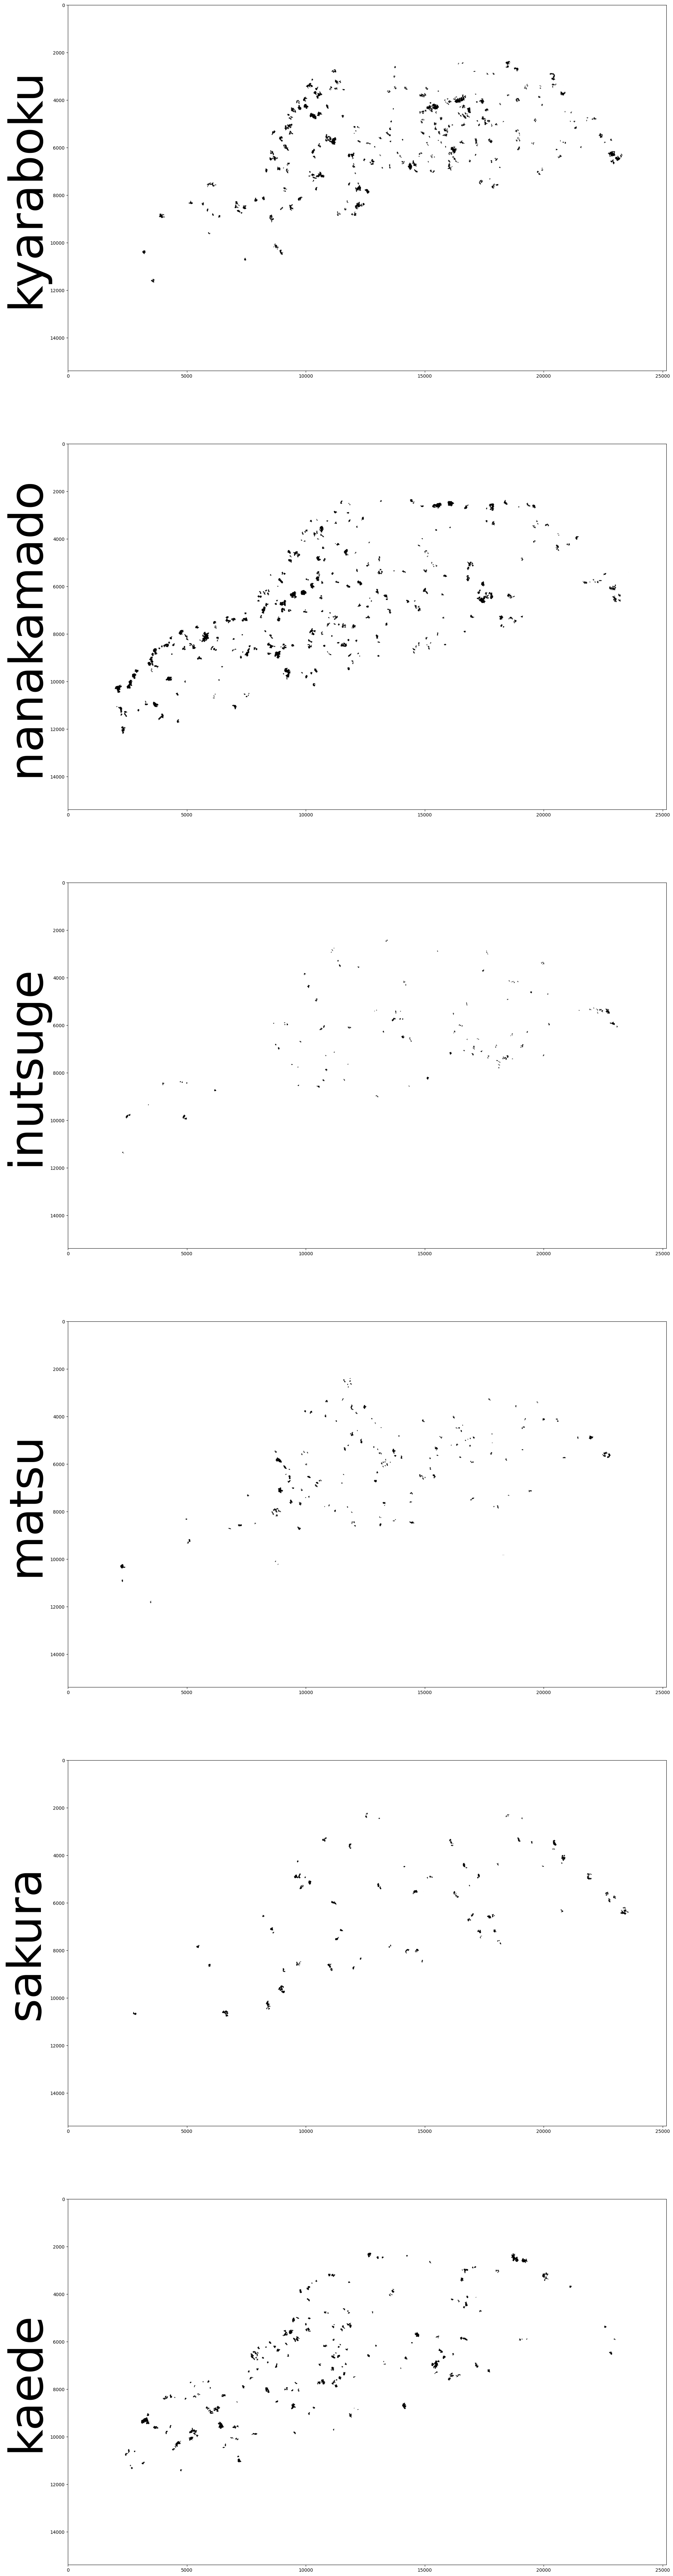

In [ ]:
#Plot them all!

plt.rcParams['figure.figsize'] = [100, 100]
f, axarr = plt.subplots(len(gt_names),1,squeeze=False)
for i in range(len(gt_names)):
    axarr[i][0].set_ylabel(gt_names[i], fontsize=100)
    axarr[i][0].imshow(gt[i],cmap=plt.cm.gray)
plt.show()

With this list of binary images we can build a label image or semantic segmentation. This image will have the same dimensions as our mosaic and species files. At each pixel we will have an integer value. "O" will indicate that this is a background pixel not belonging to any species of bush. Apart from that, a value of "1" will indicate that the pixel belongs to the firs species in gtList (which is stored in position 0), a code of "2" will indicate that the pixel belongs to the second species on the list and so on. This is often also called a semantic segmentation because it divides the original image in regions (indicated buy the value in each pixel) separated by what these regions actually "mean" in our application problem (in this case, each pixel indicates what bush species it belongs to).

In [ ]:
def buildLabelImage(gtList):
    # First, build an image of the right size but with only zero values
    labelImage = np.zeros(gtList[0].shape, dtype=np.uint8)
    for i,im in enumerate(gtList):
        # The code of each class will be its position on the gtList + 1
        labelImage[im == 0] = i+1
    return labelImage

We are now ready to build our semantic segmentation.

In [ ]:
labels = buildLabelImage(gt)

In [ ]:
plt.rcParams['figure.figsize'] = [100, 100]
plt.imshow(mosaic)
plt.imshow(labels,alpha=0.5)
plt.show()

## Assigning the correct class to each patch and store it in a file.


Now, let's try to build patches of every type using the label image. All that is left to do is:

1) Go over the list of centroids again and check their class in the label image.  
2) Once we have each patch togther with its class, put it in a nice list so we can visualize it easily.  
3) Store our final patches with class information in the hard drive of the computer:

In [ ]:
def patches_by_type(gt_names,labels,centers,patches):
    pBT = [ (t,[]) for t in gt_names ]
    for c,patch in zip(centers,patches):
        # check in the label image the code of this patch
        code = labels[int(c[1])][int(c[0])]
        if code != 0: pBT[code-1][1].append(patch)
    return pBT


def store_patches_by_type(path,pBT):
    for name,patch_list in pBT:
        for i,patch in enumerate(patch_list):
            cv2.imwrite(os.path.join(path,name+"patch"+str(i)+".jpg"),patch)

In the first function, **patches_by_type** we have created a list of tuples. Each tuple in the list contains the name of one of our species in its first component. In the second component each tuple contains a list of all of the patches that belong to this species.

If you have a close look you may realize a pesky "if code != 0: " there. Why is this here? Shouldn't each of our bushes belong to one class or another? Why would any patch be in the background? Well, the answer is that yes, all patches should be placed in some class that is not the background, but this does not always happen. The people that do the annotations are human and sometimes they miss part of the data. If you take out the if you will see that a few of our bush marking points are annotated as not belonging to any bush species. To solve this, we should print the coordinates of these points and send them back to our extremely patient foresty colleagues so they can fix the mistake (we did do that actually but I felt that it is useful to show how real data is never perfect).

In the second function **store_patches_by_type** we simply go over the list of tuples built by the previous functions and save to disk in the given path each patch as an image with a name that contains the species it belongs to and a counter.

Let's call the frst function:

In [ ]:
pBT = patches_by_type(gt_names,labels,cs,patches)
pBTToShow = patches_by_type(gt_names,labels,cs,patches_to_show)

We now have assigned a cetegory to every patch, let's show them grouped by species!

In [ ]:
# select and show a few random patches
toShow_type = 5

f, axarr = plt.subplots(len(pBT),toShow_type)
plt.rcParams['figure.figsize'] = [100, 100]

i = 0
for name,list_patches in pBTToShow:

    patches_to_show = list_patches.copy()
    np.random.shuffle(patches_to_show)
    axarr[i][0].set_ylabel(name, fontsize=100)
    for j in range(toShow_type):
            axarr[i][j].imshow(patches_to_show[j])
    i += 1

plt.show()

Finally, all that is left for us to do is store this patches with names that indicate their category. This will create a folder called "patches" in the same folder were you are running this notebook. Make sure to keep it somewhere, we will use it in our next lesson!

In [ ]:
os.makedirs("patches", exist_ok=True)
path = os.path.normpath("patches")

store_patches_by_type(path,pBT)

You can just go and have a look at the created folder and see all the files, the list of files is outputed below:

In [ ]:
os.listdir(path)

We have used basic opencv methods to read images, find the centers of points marked by experts on a binary mask, build a semantic segmentation out of series of class layers, cut patches taking advantage of the fact that images are nothing but matrices and check what was the class of each patch in the semantic segmentation to obtain a set of annotated patches.

In our next lesson we will use this set of patches to train a Deep Learning classifier that will be able to us (with a level of accuracy that we will be able to study) what class any bush patch that we give to it belongs to.